In [2]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

In [3]:
df=pd.read_excel('Project_dataset.xlsx',sheet_name='Project_dataset',header=None)

In [4]:
#import sklearn package
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [5]:
#sperate training and test dataset
X=df.iloc[:,:].values
#X_train, X_test=train_test_split(X,test_size=0.3,random_state=0)

In [6]:
from sklearn import preprocessing
import numpy as np


In [7]:
#Standarize to (0,1)
X=preprocessing.scale(X)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [8]:
#calculating covariance matrix
cov_mat=np.cov(X.T)
cov_mat.shape

(209, 209)

In [9]:
#calculating eigen_vals and eigen_vecs
eigen_vals, eigen_vecs=np.linalg.eig(cov_mat)


In [10]:
#variance explained ratios
tot=sum(eigen_vals) # sumation of eigen_value
var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)] # ratio of each eigen_value
cum_var_exp=np.cumsum(var_exp)

In [11]:
#Pareto plot
import matplotlib.pyplot as plt
plt.bar(range(len(eigen_vals)),var_exp,alpha=0.5, label='individual explained variance')
plt.step(range(len(eigen_vals)), cum_var_exp, where='post',label='cumulative explained variance') 
plt.axhline(y=0.8,color='r')
plt.ylabel('Explained variance ratio') 
plt.xlabel('Principal components') 
plt.legend(loc='best') 
plt.show()

<Figure size 640x480 with 1 Axes>

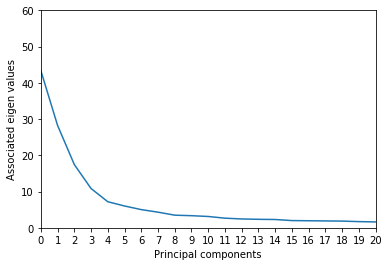

In [12]:
#Scree plot
plt.plot(range(len(eigen_vals)),sorted(eigen_vals,reverse=True))
plt.xlim(0,20)
plt.ylim(0,60)
plt.xticks(np.linspace(0,20,21))
plt.ylabel('Associated eigen values') 
plt.xlabel('Principal components')
plt.show()

In [13]:
# Determine number of PC
"""as the Scree plot says,  PCs can explain most of the varaince"""
from sklearn.decomposition import PCA
pca_num=8
pca=PCA(n_components=pca_num) # chose 20 PCs for following analysis
X_pca=pca.fit_transform(X)
X_pca.shape

(552, 8)

In [14]:
# covariance matrix of trimmed dataset
cov_mat=np.cov(X_pca.T)
cov_mat_inv=np.linalg.inv(cov_mat)
cov_mat.shape

(8, 8)

In [15]:
# X bar matrix
X_bar=[X_pca[:,i].mean() for i in range(0,pca_num)]

In [16]:
# calculating X_j-X_bar
X_sub=[X_pca[i,:]-X_bar for i in range(len(X_pca))]
X_sub=np.asmatrix(X_sub)

In [17]:
# calculating T^2 statistics
T_square=[np.float(np.matmul(np.matmul(X_sub[i,:],cov_mat_inv),X_sub[i,:].T)) for i in range(len(X_sub))]

In [18]:
#use alaph = 0.05 then the probability of the chi sqaure dist. will be
from scipy.stats import chi2
alpha=0.05
UCL=chi2.isf(alpha,pca_num)
print(UCL)

15.507313055865454


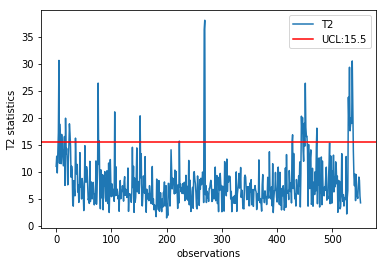

In [19]:
# ploting
plt.plot(range(len(X_pca)),T_square, label='T2')
plt.axhline(y=UCL,color='r',label='UCL:'+str(UCL)[:4])
plt.xlabel('observations') 
plt.ylabel('T2 statistics')
plt.legend(loc='best') 
plt.show()

In [20]:
# remove outlier
T_square_tr=[i for i in T_square if i<=UCL]
len(T_square_tr)
len(T_square)

552

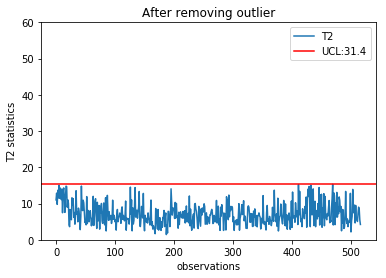

In [21]:
# ploting
plt.title('After removing outlier')
plt.plot(range(len(T_square_tr)),T_square_tr, label='T2')
plt.axhline(y=UCL,color='r',label='UCL:31.4')
plt.ylim(0,60)
plt.xlabel('observations') 
plt.ylabel('T2 statistics')
plt.legend(loc='best') 
plt.show()

In [37]:
# remove outlier of X_pca
X_pca_tr=[X_pca[i,:] for i in range(len(X_pca)) if T_square[i]<=UCL ] 
X_pca_tr=np.asarray(X_pca_tr)
X_pca_tr.shape
len(X_pca_tr)

517

In [35]:
# from previous phase1 analysis we can use sample mean and variance to represent population mean and varianc
# X bar matrix
X_bar_tr=[X_pca_tr[:][i].mean() for i in range(0,pca_num)]

In [53]:
# covariance matrix
cov_=np.cov(X_pca_tr.T)
cov_inv=np.linalg.inv(cov_)

In [124]:
# calculating m-CUSUM indexes
CUSUM_mc=np.zeros(len(X_pca_tr),dtype=float)
CUSUM_n=np.ones(len(X_pca_tr))
CUSUM_k=3.0 # detecting statistical distance of mean shift 

In [125]:
# initial cond.
import math
CUSUM_c=X_pca_tr[0]-X_bar_tr
CUSUM_mc[0]=max(0.0,math.sqrt(np.matmul(np.matmul(CUSUM_c,cov_inv),CUSUM_c.T))-CUSUM_k*CUSUM_n[0])


In [126]:
for i in range(1,len(X_pca_tr)):
    if (CUSUM_mc[i-1]!=0.0):
        CUSUM_n[i]=CUSUM_n[i-1]+1
    CUSUM_c=sum(X_pca_tr[(i-int(CUSUM_n[i])+1):i+1]-X_bar_tr) 
    CUSUM_mc[i]=max(0.0,math.sqrt(np.matmul(np.matmul(CUSUM_c,cov_inv),CUSUM_c.T))-CUSUM_k*CUSUM_n[i])

In [127]:
CUSUM_n

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35.,  1.,  2.,  3.,  1.,
        1.,  1.,  2.,  1.,  1.,  2.,  3.,  4.,  1.,  2.,  3.,  4.,  5.,
        6.,  1.,  2.,  1.,  2.,  3.,  4.,  5.,  6.,  1.,  1.,  2.,  3.,
        1.,  2.,  3.,  1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  1.,
        2.,  1.,  2.,  3.,  4.,  5.,  6.,  1.,  1.,  2.,  1.,  2.,  1.,
        2.,  3.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  3.,  1.,  2.,  3.,
        1.,  2.,  3.,  1.,  2.,  3.,  4.,  5.,  1.,  1.,  2.,  1.,  2.,
        3.,  4.,  1.,  2.,  3.,  4.,  1.,  2.,  3.,  1.,  2.,  3.,  1.,
        1.,  1.,  2.,  3.,  1.,  2.,  3.,  4.,  1.,  2.,  3.,  4.,  1.,
        2.,  3.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12.,  1.,  2.,  3.,  1.,  2.,  1.,  2.,  3.,  1.,  2.,  1.,  2.,
        3.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  1.,  1.,  1.,  2

In [128]:
CUSUM_mc

array([6.46960942e-01, 1.34554094e+00, 2.00463252e+00, 2.93864716e+00,
       3.63002544e+00, 5.87972524e+00, 6.95607742e+00, 6.56392436e+00,
       8.12205546e+00, 8.48355865e+00, 1.03145546e+01, 7.82120459e+00,
       8.98383665e+00, 1.14357207e+01, 1.25688085e+01, 1.28961659e+01,
       1.41473711e+01, 1.59676271e+01, 1.73887178e+01, 1.82633626e+01,
       1.85612841e+01, 1.98794129e+01, 1.89580987e+01, 1.68404226e+01,
       1.46770941e+01, 1.28901302e+01, 1.10087152e+01, 8.01933145e+00,
       7.30595797e+00, 8.97021409e+00, 6.26000418e+00, 4.69270779e+00,
       3.08466068e+00, 9.14476362e-01, 0.00000000e+00, 9.06834942e-01,
       9.01084416e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.11420559e+00, 0.00000000e+00, 0.00000000e+00, 2.41935697e+00,
       8.18772038e-01, 4.14442841e-01, 0.00000000e+00, 1.83957387e+00,
       7.03585096e-01, 1.18041755e+00, 5.76465434e-01, 2.44818912e-01,
       0.00000000e+00, 7.95277125e-01, 0.00000000e+00, 8.95094240e-01,
      

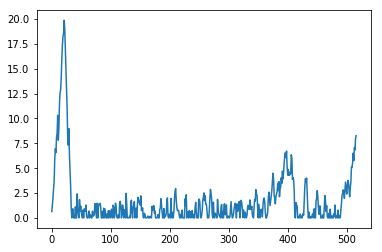

In [129]:
#plotting
plt.plot(range(len(CUSUM_mc)),CUSUM_mc)
plt.show()

In [186]:
# mewma
mewma_lamda=0.3
mewma_z=np.zeros((len(X_pca_tr),len(X_pca_tr[0,:])))
mewma_z[0,:]=X_bar_tr

In [187]:
# Giving value to z
for i in range(1,len(X_pca_tr)):
    mewma_z[i,:]=mewma_lamda*X_pca_tr[i,:]+(1-mewma_lamda)*mewma_z[(i-1),:]

In [196]:
# cov of z
cov_z=np.cov(mewma_z.T)
cov_z_inv=np.linalg.inv(cov_z)
# z sub
mewma_z_sub=mewma_z-X_bar_tr

In [197]:
# T2 of mEWMA
mewma_t=[np.float(np.matmul(np.matmul(mewma_z_sub[i,:],np.linalg.inv(np.cov(mewma_z.T))),mewma_z_sub[i,:].T)) for i in range(len(mewma_z_sub))]
    

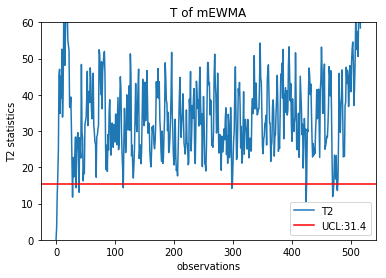

In [198]:
#plotting
plt.title('T of mEWMA')
plt.plot(range(len(mewma_t)),mewma_t, label='T2')
plt.axhline(y=UCL,color='r',label='UCL:31.4')
plt.ylim(0,60)
plt.xlabel('observations') 
plt.ylabel('T2 statistics')
plt.legend(loc='best') 
plt.show()

In [201]:
cov_z=np.cov(mewma_z[i,:].T)
cov_z

array(5.19630994)